# Ensemble Learning

## Contents
- Bias-Variance Decomposition
    - Mathematical Definition
    - Decomposition of Expected Test Error
- Ensembles
- Bootstrap Aggregating (Bagging)
    - Bootstraps
    - Result Aggregating
- Random Forests
    - Variable Importance: OOB
- Adaptive Boosting (AdaBoost)
    - AdaBoost Algorithm
- Gradient Boosting Machine (GBM)
- XGBoost - 피피티는 여기까지!
- LightGBM
- CatBoost

--------------

## Bias-Variance Decomposition

Bias-Variance Decomposition 은 모델의 일반화 성능을 높히기 위한 정규화 방법론들과 앙상블 방법론들의 이론적 배경이다. 실제 데이터로 학습되는 모든 모델은 어느정도의 Bias-Variance tradeoff 가 존재하기 때문에, 수리적 배경을 이해하여 모델의 성능을 높히기 위한 적절한 조치를 취해줘야 한다.

<p align="center">
    <img src="ensemble_images/bvd.png" width="400"/>
</p>

**Error Due to Bias:** 모델의 Expected prediction 과 실제 값의 차이다. 모델의 Expected prediction 이란, 같은 분포에서 나온 많은 데이터셋을 통해 많은 모델을 학습시켰을 때 해당 모델들의 평균 예측치다.

**Error Due to Variance:** 같은 분포에서 나온 많은 데이터셋을 통해 모델을 학습시켰을 때, 한 데이터포인트에 대한 전체 평균 예측치와 개별 모델의 예측치의 차이를 의미한다. 즉, 전체 모델들간의 예측치의 차이로 해석할 수 있다.

Bias 는 모델들의 전반적인 성능이 좋은지 나쁜지를 의미하고, Variance 는 각 모델들이 서로와 얼마나 다른지를 의미한다. 머신러닝의 대부분의 모델은 둘중 하나가 높다는 특징을 가지고 있기 때문에 Bias-Variance Tradeoff 라고 불린다.

특정 모델을 학습시켰을 때 test error 는 필연적으로 등장한다. Bias-Variance Decomposition 은 해당 error 가 Bias 에서 온 error 인지, variance 에서 온 error 인지, noise 에서 온 error 인지 평가해 줄 수 있다.

### Mathematical Definition

> 해당 Tutorial 의 Mathematical Definition 파트는 [Cornell CS4780 SP17](https://www.youtube.com/watch?v=zUJbRO0Wavo) Killian Weinberger 교수님의 강의를 참고하였습니다.

$P(X,Y)$ 라는 분포에서 i.i.d 로 데이터셋 $D = \{(\mathbf{x}_1, y_1), \dots, (\mathbf{x}_n,y_n)\}$ 를 추출했다고 가정하자. Regression 모델을 가정했을 때, 모든 벡터 $\mathbf{x_n}$ 에 대한 정답 라벨 $y_n$ 은 unique 하지 않고, 분포에 따라 주어진다.

> 영상에서 이 부분에 대해 갸우뚱하는 학생들을 위해 교수님이 직접 예시를 들어준다. 집에 대한 가격을 나타내는 데이터셋에 대해, 설명변수의 값이 모두 동일한 두개의 집은 무조건적으로 가격이 같지 않다.

**Expected Label:**

$$
\bar{y}(\mathbf{x}) = E_{y \vert \mathbf{x}} \left[Y\right] = \int\limits_y y \, \Pr(y \vert \mathbf{x}) \partial y
$$

i.i.d 로 추출한 수많은 데이터셋들에 대해 모델을 학습시킨 뒤, 새로운 샘플 $\mathbf{x}$ 에 대한 expected label 은 위와 같이 계산할 수 있다. 데이터셋 자체를 $P(X,Y)$ 라는 분포에서 i.i.d 추출했기 때문에 random variable 로 취급할 수 있으므로, continuous r.v. 의 Expectation 을 구하는 것과 동일하게 $y$ 값과 모델의 예측치들에 대해 $y$ 로 미분해주면 된다.

**Expected Test Error (given $h_D$):**

$$
E_{(\mathbf{x},y) \sim P} \left[ \left(h_D (\mathbf{x}) - y \right)^2 \right] = \int\limits_x \! \! \int\limits_y \left( h_D(\mathbf{x}) - y\right)^2 \Pr(\mathbf{x},y) \partial y \partial \mathbf{x}.
$$

$D$ 라는 학습 데이터를 통해 알고리즘 $\mathcal{A}$ 를 학습시켰다고 가정하자 ($h_D = \mathcal{A}(D)$).  그렇다면 해당 모델 $h_D$ 의 Expected Test Error 은 (예시가 regression 이기 때문에 squared loss 사용) 위와 같이 구할 수 있다. $D$ 는 앞서 설명했듯이 random variable 로 취급할 수 있고, $h_D$ 는 $D$ 에 대한 function 이기 때문에 마찬가지로 random variable 이다.

**Expected Classifier (given $\mathcal{A}$):**

$$
\bar{h} = E_{D \sim P^n} \left[ h_D \right] = \int\limits_D h_D \Pr(D) \partial D
$$

**$h_D$ 와 $\mathcal{A}$ 를 구분짓는게 핵심이다.** $h_D$ 는 하나의 모델이고 $\mathcal{A}$ 는 학습될 수 있는 모든 모델이다. 그렇기 때문에 위와 같이 expected classifer 은 분포 $P$ 에서 추출된 $D$ 로 학습된 모든 모델의 expectation 이라고 할 수 있다.

**Expected Test Error (given $\mathcal{A}$):**

$$
\begin{equation*}
E_{\substack{(\mathbf{x},y) \sim P\\ D \sim P^n}} \left[\left(h_{D}(\mathbf{x}) - y\right)^{2}\right] = \int_{D} \int_{\mathbf{x}} \int_{y} \left( h_{D}(\mathbf{x}) - y\right)^{2} \mathrm{P}(\mathbf{x},y) \mathrm{P}(D) \partial \mathbf{x} \partial y \partial D
\end{equation*}
$$

모든 모델에 대한 expectation 을 구했기 때문에 이제 **가능한 모든 모델에 대한 expected error 을 표현 할 수 있다.** 우리의 목적은 $P(X,Y)$ 에서 추출된 $D$ 로 학습된 모델 $\mathcal{A}$ 의 expected 성능을 구하는 것이기 때문에, 위 식이 이를 나타낸다. 이때 해당 식을 decompose 하면 정확히 어떻게 모델의 에러가 구성되어있는지 볼 수 있다.

### Decomposition of Expected Test Error (given $\mathcal{A}$)

$$
E_{\mathbf{x},y,D}\left[\left[h_{D}(\mathbf{x}) - y\right]^{2}\right]
\\
\\
= E_{\mathbf{x},y,D}\left[\left[\left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x})\right) + \left(\bar{h}(\mathbf{x}) - y\right)\right]^{2}\right]
\\\\
= E_{\mathbf{x}, D}\left[(\bar{h}_{D}(\mathbf{x}) - \bar{h}(\mathbf{x}))^{2}\right]
\\
+2 \mathrm{\;} E_{\mathbf{x}, y, D} \left[\left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x})\right)\left(\bar{h}(\mathbf{x}) - y\right)\right] 
\\
+E_{\mathbf{x}, y} \left[\left(\bar{h}(\mathbf{x}) - y\right)^{2}\right]
$$

첫 식은 위에서 구한 Expected Test Error 이다. 이때 expectation 안에 모델의 label 의 expectation $\bar{h}(\mathbf{x})$ 를 한번씩 빼주고 더해준다. 이를 binomial expansion 을 통해 마지막 식처럼 표현 할 수 있다. 복잡해 보이지만 결국 $(a+b)^2 = a^2+2ab+b^2$ 의 꼴이다. 이때 식의 $2ab$ 부분은 0이 된다.

$$
E_{\mathbf{x}, y, D} \left[ \left( h_{D}(\mathbf{x}) - y \right)^{2} \right] = \underbrace{E_{\mathbf{x}, D} \left[ \left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x}) \right)^{2} \right]}_\mathrm{Variance} + E_{\mathbf{x}, y}\left[ \left( \bar{h}(\mathbf{x}) - y \right)^{2} \right]
$$

Variance 의 정의 자체가 해당 객체가 평균에서 얼마나 분산되어있는지 이기 때문에, 식의 첫번째 부분을 Variance 라고 할 수 있다. 식의 두번째 부분은 처음에 진행 한 것 처럼 binomial expansion 꼴로 표현하면 아래와 같아진다.

$$
E_{\mathbf{x}, y} \left[ \left(\bar{h}(\mathbf{x}) - y \right)^{2}\right] = E_{\mathbf{x}, y} \left[ \left(\bar{h}(\mathbf{x}) -\bar y(\mathbf{x}) )+(\bar y(\mathbf{x}) - y \right)^{2}\right]  \\\\
=\underbrace{E_{\mathbf{x}, y} \left[\left(\bar{y}(\mathbf{x}) - y\right)^{2}\right]}_\mathrm{Noise} + \underbrace{E_{\mathbf{x}} \left[\left(\bar{h}(\mathbf{x}) - \bar{y}(\mathbf{x})\right)^{2}\right]}_\mathrm{Bias^2} \\
+ 2 \mathrm{\;} E_{\mathbf{x}, y} \left[ \left(\bar{h}(\mathbf{x}) - \bar{y}(\mathbf{x})\right)\left(\bar{y}(\mathbf{x}) - y\right)\right] 
$$

동일하게 $2ab$ 부분은 사라지기 때문에, 최종적으로 expected test error 의 decomposition 은 다음과 같아진다:

$$
\underbrace{E_{\mathbf{x}, y, D} \left[\left(h_{D}(\mathbf{x}) - y\right)^{2}\right]}_\mathrm{Expected\;Test\;Error}
\\
= \underbrace{E_{\mathbf{x}, D}\left[\left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x})\right)^{2}\right]}_\mathrm{Variance} + \underbrace{E_{\mathbf{x}, y}\left[\left(\bar{y}(\mathbf{x}) - y\right)^{2}\right]}_\mathrm{Noise} + \underbrace{E_{\mathbf{x}}\left[\left(\bar{h}(\mathbf{x}) - \bar{y}(\mathbf{x})\right)^{2}\right]}_\mathrm{Bias^2}
$$

**즉, Bias-Variance decomposition 은 한 머신러닝 알고리즘의 expected test error (혹은 성능) 은 3개의 요인으로 나누어 설명할 수 있음을 의미한다. 한개의 모델이 다른 모델들과 얼마나 다른지를 설명하는 Variance, 전체 모델들의 평균 예측치와 실제값들의 평균의 차를 나타내는 Bias (평균 성능이라고 봐도 무방하다), 그리고 설명할 수 없는 data intrinsic 한 noise 의 합으로 하나의 모델의 성능을 나타낼 수 있다.**

이상적인 알고리즘은 Bias 와 Variance 가 낮지만, 현실적으로 tradeoff 가 발생하기 때문에 필연적으로 둘중 하나는 크다. 보통 Model Compexity 가 낮은 알고리즘들 (ex. LogReg, LDA) 는 High Bias Low Variance 이며, Model Complexity 가 높은 알고리즘들 (ex. NN, Full DT, SVM) 은 Low Bias High Variance 이다.

<p align="center">
    <img src="ensemble_images/bvd2.jpg" width="400"/>
</p>

위의 그래프를 보면 Model complexity 가 높을수록 높은 Variance 를 가졌다는 의미가 와닿는다. Training sample 에 대한 에러율은 0에 수렴하지만, 같은 분포에서 추출한 또다른 데이터셋인 testing sample 에 대한 에러는 굉장히 높다. 이는 데이터셋의 작은 변화에도 모델이 민감하게 반응한다는 것을 의미하며, 자주 접하는 과적합이 해당 모델들의 고질적인 문제를 표현한다.



-------------------

## Ensembles

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import warnings
warnings.filterwarnings('ignore')


이상적인 모델은 Bias 와 Variance 가 낮아야 하지만, 모델의 complexity 에 따라 현실적으론 Bias-Variance Tradeoff 에 의해 둘 중 하나는 필연적으로 높다.

이를 해결하기 위해 등장한 방법론들의 모음을 **Ensemble** 이라고 하는데, 이름에서 알 수 있듯이 개별적으로 어느정도의 성능을 내는 여러개의 모델을 합쳐 최종적인 성능을 끌어올리는 방법론들이다. 앙상블 방법론들은 수행하고자 하는 task 로 인해 크개 두가지 갈래로 나눌 수 있다:

- Bagging: Decreases Variance

- Boosting: Decreases Bias

--------------------

## Bootstrap Aggregating (Bagging)

### Bootstraps

In [3]:
x = [f'x_{i}' for i in range(1, 11)]
y = [f'y_{i}' for i in range(1, 11)]
df = pd.DataFrame({'Original': x, 'Data': y})
b1 = df.sample(frac=1, replace=True).reset_index(drop=True)
b1.columns=['Bootstrap','1']
b2 = df.sample(frac=1, replace=True).reset_index(drop=True)
b2.columns=['Bootstrap','2']
pd.concat([df, b1, b2], axis=1)

,Original,Data,Bootstrap,1,Bootstrap,2
0,x_1,y_1,x_8,y_8,x_2,y_2
1,x_2,y_2,x_10,y_10,x_1,y_1
2,x_3,y_3,x_8,y_8,x_5,y_5
3,x_4,y_4,x_4,y_4,x_7,y_7
4,x_5,y_5,x_3,y_3,x_2,y_2
5,x_6,y_6,x_8,y_8,x_9,y_9
6,x_7,y_7,x_5,y_5,x_2,y_2
7,x_8,y_8,x_4,y_4,x_7,y_7
8,x_9,y_9,x_9,y_9,x_4,y_4
9,x_10,y_10,x_5,y_5,x_3,y_3


Bagging 은 특정 모델의 분산을 낮춰주는 학습 방법론이다. 위 테이블을 예시로 기존 데이터셋은 10개의 샘플을 가지고 있다. 이때 기존 데이터셋에서 10개의 샘플을 random 으로 복원추출을 하여 $B$ 개의 새로운 데이터셋, 즉 Bootstrap 을 생성한다.

해당 Bootstrap 들로 동일한 알고리즘을 학습 한 뒤, 결과를 하나로 합치는 것이 Bagging 의 핵심이다. 이때 알고리즘은 지도학습 알고리즘이면 어떤 것을 사용해도 무방하지만, **Bagging 은 앞서 언급하였듯이 high model complexity 를 가진 알고리즘들에 효과적이다.** Bagging 자체는 알고리즘이 아니라 앙상블의 다양성을 확보하기 위한 방법론 중 하나이기 때문에, 어떤 알고리즘을 사용하냐에 따라 Bagging with Neural Networks, Bagging with SVM 등으로 불리는 명칭이 달라진다.

In [39]:
df = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan']
X

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,1,0


사용한 데이터셋은 [Bank Personal Loan Modelling](https://www.kaggle.com/datasets/teertha/personal-loan-modeling) 으로, 총 13개의 설명변수로 해당 고객이 제시된 대출상품을 수락했는지 거절했는지 분류하는 binary classification task 에 사용되는 대표적인 toy dataset 이다.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

n_estimators = 15
ensemble = BaggingClassifier(base_estimator=LogisticRegression(),
            n_estimators=n_estimators,
            bootstrap=True,
            random_state=42)
ensemble.fit(X_train, y_train)
ensemble.score(X_test, y_test)

print(f'Test accuracy of a single Logistic regression model: {base_model.score(X_test, y_test)}')
print(f'Test accuracy of a Bagging ensemble of {n_estimators} Logistic regression models: {ensemble.score(X_test, y_test)}')


Test accuracy of a single Logistic regression model: 0.908
Test accuracy of a Bagging ensemble of 15 Logistic regression models: 0.913


결과에서 확인 할 수 있듯이 단일 모델보다 20개의 모델의 앙상블을 사용했을 시 Test accuracy 가 증가한다. 그렇다면 Bagging Ensemble 에서 20개의 모델을 합치는 방법론인 Result Aggregating 을 알아보자.

### Result Aggregating

$B$ 개의 Bootstrap 으로 $B$ 개의 모델을 학습시켰다면, 최종적으로 이 모델들을 하나로 합쳐야 한다. Bagging 에서 이 단계를 Result Aggregating 이라 하며, 다양한 방법론들이 있다.

#### Majority Voting

각 모델의 결과를 합치는 방법론 중 가장 간단한 방법론인 Majority Voting 은, 과반수의 예측값을 최종 예측값으로 선택하는 것이다.

$$
\hat y_{Ensemble}=argmax(\sum_{j=1}^n\delta(\hat y_j=i), \ i \in \{0,1\})
$$



In [45]:
test_sample_index = X_test.sample(n=1).index.item()
test_sample = X_test.loc[test_sample_index].to_numpy().reshape(1, -1)
test_sample_y = y_test.loc[test_sample_index]

model_name=[]
model_score=[]
test_sample_prob=[]
predicted_label=[]
for i, model in enumerate(ensemble.estimators_):
    model_name.append(f'Model {i+1}')
    model_score.append(model.score(X_test, y_test))
    test_sample_prob.append(model.predict_proba(test_sample)[0][1])
    predicted_label.append(model.predict(test_sample)[0])

maj_vote = pd.DataFrame({'Ensemble Population':
                            model_name,     
                        'Test Accuracy':
                            model_score,
                        'P(y=1) for a test sample':
                            test_sample_prob,
                        'Predicted Label':
                            predicted_label})
maj_vote

,Ensemble Population,Test Accuracy,P(y=1) for a test sample,Predicted Label
0,Model 1,0.908,0.140973,0
1,Model 2,0.910,0.149015,0
2,Model 3,0.907,0.124695,0
3,Model 4,0.907,0.163355,0
4,Model 5,0.909,0.144366,0
5,Model 6,0.908,0.196135,0
6,Model 7,0.909,0.118339,0
7,Model 8,0.910,0.122437,0
8,Model 9,0.903,0.151069,0
9,Model 10,0.912,0.163708,0


각 모델은 새로 들어온 test sample 에 대해 class 1 에 포함될 확률과, 0.5 로 설정된 cutoff 로 sample 에 대한 최종 예측 class 를 보여준다. 이때 Majority Voting 은 단순히 15개의 모델 모두 샘플이 class 0 이라고 예측하였기 때문에, 해당 샘플에 대한 앙상블의 최종 예측값은 0이 된다.

#### Weighted Voting
각 모델의 결과에 가중치를 부여해서 합칠 수 있는데, 가중치를 각 모델의 Test Accuracy 로 설정한 예시는 다음과 같다.

$$
\hat y_{Ensemble}=argmax \left( {\sum_{j=1}^n(TestAcc_j) \cdot \delta(\hat y_j=i) \over \sum_{j=1}^n(TestAcc_j)}, \ i \in \{0,1\} \right)
$$

$$
\delta = \text{Counting function}
$$

각 class 의 Test Accuracy 의 합을 전체 Test Accuracy 의 합으로 나눠줌으로써 정규화를 진행해준다. 높은 Test Accuracy 는 모델의 신뢰도가 높다는 것을 의미하기 때문에, 이를 가중치로 반영한 방법론이다.

In [46]:
test_sum = sum(maj_vote['Test Accuracy'])
test_sum_class_0 = sum(maj_vote.loc[maj_vote['Predicted Label']==0]['Test Accuracy'])
test_sum_class_1 = sum(maj_vote.loc[maj_vote['Predicted Label']==1]['Test Accuracy'])
weighted_vote_class_0 = test_sum_class_0/test_sum
weighted_vote_class_1 = test_sum_class_1/test_sum
print(f'Weighted Vote for Class 0: {weighted_vote_class_0}')
print(f'Weighted Vote for Class 1: {weighted_vote_class_1}')

Weighted Vote for Class 0: 1.0
Weighted Vote for Class 1: 0.0


----------------

## Random Forests

Bagging 은 굉장히 직관적인 앙상블 기법이다. 복원추출로 동일한 샘플수를 가진 bootstrap 을 생성하고, 모델들을 학습시킨 뒤 적절히 결합하여 complex 한 모델의 분산을 줄인다. High complexity 를 가진 그 어떤 모델에 bagging 을 적용할 수 있고, base learner (기준이 되는 학습 알고리즘) 에 따라 bagging with SVM 등으로 불린다. 반면 Random Forest 는 **의사결정나무에 bagging 을 적용한 모델로,** 특별히 혼자 다르게 불리는 이유는 OOB 데이터셋에 의한 추가적인 insight 도출 능력과 bagging 에 있어 모든 설명변수를 사용하지 않는다는 특징이 있기 때문이다.

<p align="center">
    <img src="ensemble_images/rf1.png" width="400"/>
</p>

Random Forest 는 기존 Bagging 을 사용하지만, Bootstrap 을 이용한 학습 단계에서 모든 설명변수를 사용하지 않고 random 한 설명변수의 subset 만으로 학습을 진행한다는 특징을 가지고 있다. 이러한 과정으로 통해 Random Forest 는 Bagging 으로 다양성 확보를 하고, 설명변수를 random 하게 추출함으로써 다양성을 추가적으로 더 확보할 수 있다.

> 학부생때 교수님께서 Random Forest 를 설명해주셨을 때, 설명변수의 subset 만으로 학습하는 특징을 '2보 전진을 위한 1보 후퇴' 라고 표현하셨던 것이 기억에 남습니다.

예시로 사용할 데이터셋은 [Pumpkin Seeds Dataset](https://www.kaggle.com/datasets/muratkokludataset/pumpkin-seeds-dataset?datasetId=2033872&sortBy=voteCount) 으로, 총 12개의 설명변수로 pumpkin seed 의 종류를 분류하는 binary classification task 에 사용되는 dataset 이다.

In [49]:
df = pd.read_excel('Pumpkin_Seeds_Dataset.xlsx')
df = df.replace({'Çerçevelik': 0, 'Ürgüp Sivrisi': 1})
X = df.drop('Class', axis=1)
y = df['Class']
X

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness
0,56276,888.242,326.1485,220.2388,56831,267.6805,0.7376,0.9902,0.7453,0.8963,1.4809,0.8207
1,76631,1068.146,417.1932,234.2289,77280,312.3614,0.8275,0.9916,0.7151,0.8440,1.7811,0.7487
2,71623,1082.987,435.8328,211.0457,72663,301.9822,0.8749,0.9857,0.7400,0.7674,2.0651,0.6929
3,66458,992.051,381.5638,222.5322,67118,290.8899,0.8123,0.9902,0.7396,0.8486,1.7146,0.7624
4,66107,998.146,383.8883,220.4545,67117,290.1207,0.8187,0.9850,0.6752,0.8338,1.7413,0.7557
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,79637,1224.710,533.1513,190.4367,80381,318.4289,0.9340,0.9907,0.4888,0.6672,2.7996,0.5973
2496,69647,1084.318,462.9416,191.8210,70216,297.7874,0.9101,0.9919,0.6002,0.7444,2.4134,0.6433
2497,87994,1210.314,507.2200,222.1872,88702,334.7199,0.8990,0.9920,0.7643,0.7549,2.2828,0.6599
2498,80011,1182.947,501.9065,204.7531,80902,319.1758,0.9130,0.9890,0.7374,0.7185,2.4513,0.6359


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tree = DecisionTreeClassifier(max_depth=5, random_state=0)
tree.fit(X_train, y_train)

n_estimators = 5
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=5,random_state=0)
rf.fit(X_train, y_train)

n_estimators_random = [i for i in range(1,21)]
max_depth = [i for i in range(1, 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'n_estimators': n_estimators_random,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

best_random = rf_random.best_estimator_
best_random.fit(X_train, y_train)

print(f'Test accuracy of a single Decision Tree model: {tree.score(X_test, y_test)}')
print(f'Test accuracy of a Random Forest ensemble of {n_estimators} Decision Tree models: {rf.score(X_test, y_test)}')
print(f'Test accuracy of a Random Forest ensemble of {n_estimators} Decision Tree models with Randomized Search: {best_random.score(X_test, y_test)}')

print(f'Parameters of the best Random Forest model: \n {rf_random.best_params_}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test accuracy of a single Decision Tree model: 0.848
Test accuracy of a Random Forest ensemble of 5 Decision Tree models: 0.856
Test accuracy of a Random Forest ensemble of 5 Decision Tree models with Randomized Search: 0.864
Parameters of the best Random Forest model: 
 {'n_estimators': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 8}


결과에서 확인 할 수 있듯이 단일 모델보다 Random Forest 를 사용했을 시 Test accuracy 가 증가한다. 추가적으로 Random grid search 를 통해 hyperparameter optimization 진행 시, 더욱 좋은 모델이 학습된다.

### Variable Importance: OOB

앙상블 방법론 중 Bagging 은 각 bootstrap 을 만들때 복원추출을 한다. 그렇기에 bootstrap 수가 아무리 많아도, 확률적으로 단 한번도 bootstrap 에 포함되지 않는 샘플들이 있기 마련이다.

이를 OOB Data (Out-of-bag) 라고 하며, 앙상블의 개별 모델의 Validation Set 으로 쓰인다. 통상적인 머신러닝 모델을 학습시킬 때 데이터셋을 Train/Validation/Test set 으로 나누어 학습을 진행하지만, OOB의 존재 덕분에 따로 Validation Set 을 빼놓지 않고 보다 더 많은 Training sample 을 쓸 수 있다는 장점이 있다.

앙상블 모델중에서 Random Forest 는 실무에서 활용도가 굉장히 높은 모델이다. 바로 OOB Data 로 설명변수의 중요도를 구할 수 있기 때문이다.



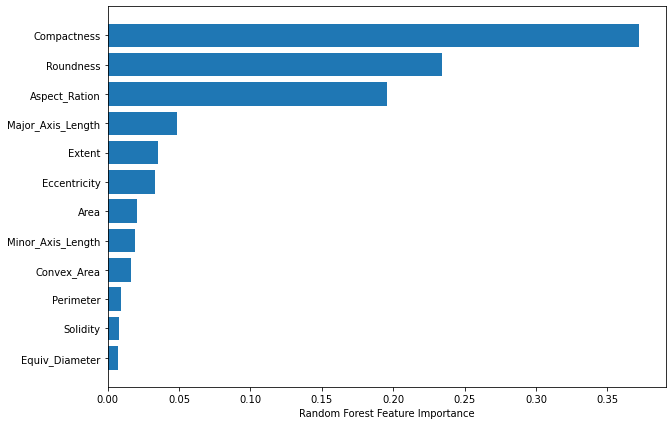

In [95]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=(10, 7))
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

**Step 1:** Population (앙상블을 구성하는 개별 모델) 에 대해 OOB error ($e_i$) 를 계산한다.

**Step 2:** 중요도를 구하고자 하는 설명변수 $x_i$ 의 값들에 대해 random permutation 을 진행 후, permutated OOB error ($p_i$) 를 계산한다.

**Step 3:** Population 에 대해 $p_i - e_i$ 의 평균과 분산을 구한 뒤, 변수의 중요도를 산출한다.

이때 Step 2 의 random permutation 은 해당 변수에 대한 sample 의 값을 random 하게 섞는 것을 의미한다. 만약 Random Forest 에서 변수 $x_i$ 의 중요도가 높다면, $p_i - e_i$ 의 값은 커야 하며 편차가 적어야 한다.

$$
d_i^m = p_i^m - e_i^m
\\
\bar d_i = {1\over m}\sum_{i=1}^m d_i^m
\\
s_i^2 = {1 \over m-1} \sum_{i=1}^m (d_i^m - \bar d_i)^2
\\
v_i = {\bar d_i \over s_i}
$$

$d_i^m$ 은 m 번째 tree 에서 설명변수 i 에 대해 permutation 전후 OOB error 의 차이를 나타내고, 이에 따른 평균을 분자로, 분산을 분모로 두어 변수의 중요도 $v_i$ 를 구할 수 있다. 

---------------

## Adaptive Boosting (AdaBoost)

Bagging 은 bootstrap 을 만들어 high model complexity 를 가진 모델을 학습시킨 뒤, 적절히 결합하는 앙상블 방법론이다. **Boosting 은 반대로 하나의 데이터셋에 하나의 모델을 학습시킨 후, 풀어내지 못한 것에 대해 다음단계에서 중점적으로 학습을 반복하는 방법론이다.**

Boosting 에선 Strong vs. Weak model 이란 개념이 등장한다. Classifier 기준으로, Weak model 은 random guessing 보다 성능이 아주 약간 좋은 모델을 의미하며, boosting 은 이런 Weak model 을 기준으로 Strong model 을 향해 나아간다. Boosting 은 데이터셋을 통해 성능이 아주 낮은 weak model 을 먼저 학습시킨 뒤, 오분류한 데이터셋 속 샘플에 대해 가중치를 부여하고 새로운 모델의 학습을 반복한다. 이렇기 때문에 bagging 과는 달리 병렬연산이 불가능하다.

<p align="center">
    <img src="ensemble_images/baggingvboosting.png" width="400"/>
</p>


> Bagging 은 병렬처리가 가능하고, Boosting 은 병렬처리가 불가능하지만 실제로는 Boosting 의 학습이 훨씬 빠른 경우를 종종 볼 수 있다. Bagging 은 애초에 High complexity 를 가진 모델을 병렬 연산하는 것이고, Boosting 은 Weak model 을 직렬연산하는 것이다. 하지만 오히려 Weak model 의 직렬연산이 Bagging 의 high complexity 모델 하나를 학습시키는것보다 빠른 경우가 많다.

Adaptive boosting 은 Boosting 방법론 중 weak model 을 stump tree 로 사용하는 앙상블 방법론이다. Stump tree 란 decision boundary split 을 단 1번만 진행한 Decision tree 를 의미하며, (제대로 학습이 이루어졌다고 가정하면) random guessing 보다 성능이 약간 좋다는 특징을 가진다.

### AdaBoost Algorithm

<p align="center">
    <img src="ensemble_images/adaboost1.png" width="400"/>
</p>


1. AdaBoost 의 지정 hyperparameter $T$ 는 individual learner 의 개수를 의미한다. AdaBoost 는 직렬연산을 기반한 알고리즘이기 때문에, individual learner 의 개수는 곧 알고리즘의 iteration 을 의미한다. 보통 50~100개를 지정한다.

2. AdaBoost 의 Input 은 $N$ 개의 정답 pair 을 가진 학습 데이터셋 $S$ 다. 이때 주목할만한 점은 정답라벨 $y_i$ 다. 일반적인 Classification 을 수행하기 위해 데이터셋의 정답라벨은 $0,1$ 의 값을 갖는데 AdaBoost 의 특성상 $-1, 1$ 을 사용한다. 예측하는데 있어 아무런 차이가 없지만, 이렇게 값을 바꾸어 사용하는 이유는 weight update 에서 확인 할 수 있다.


In [103]:
df = pd.read_excel('Pumpkin_Seeds_Dataset.xlsx')
df = df.replace({'Çerçevelik': -1, 'Ürgüp Sivrisi': 1})
df['Class'].value_counts()

-1    1300
 1    1200
Name: Class, dtype: int64

3. $D_1(i)$ 는 1번째 iteration 에서 sample $i$ 가 선택될 확률분포를 의미한다. **알고리즘 초기엔 일양분포를 사용함으로써 $i$ 가 선택될 확률은 다른 sample 들과 동일하지만, iteration 이 진행되며 이 분포는 바뀐다.**

4. for loop 을 이용해서 individual learner 의 개수만큼 알고리즘을 반복한다.

   4-1. 확률분포 $D_t$ 를 이용하여 모델 $h_t$ 를 학습시킨다. 여기서 주목할 점은 AdaBoost 의 학습용 데이터셋 생성은 Boosting 과 마찬가지로 복원추출을 사용하지만, 첫번째 iteration 에서만 복원추출하는 방식이 Uniform distribution 이기 때문에 random 하다. 이때 $h_t$ 는 Stump tree 를 의미한다.


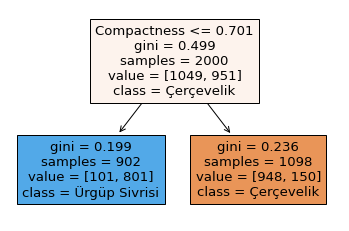

In [105]:
df_1 = df.sample(frac=1, replace=True, random_state=42)
X_1 = df.drop('Class', axis=1)
y_1 = df['Class']
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
tree_1 = DecisionTreeClassifier(max_depth=1)
tree_1.fit(X_train_1, y_train_1)
plot_tree(tree_1, feature_names=X_1.columns, class_names=['Çerçevelik', 'Ürgüp Sivrisi'], filled=True);

   4-2. 오분류율인 $\epsilon_t = P_{D_t}(h_t(x)\neq y)$ 을 계산한다.


In [118]:
acc = accuracy_score(y_train_1, tree_1.predict(X_train_1))
err_1 = 1 - acc
err_1

0.12549999999999994

   4-3. 오분류율 $\epsilon_t \geq 0.5$ 면 알고리즘을 종료하고 다시 처음부터 시작한다. 학습한 모델은 weak model 인 stump tree 이기 때문에, 아무리 성능이 낮을지언정 random guessing 보다 성능이 좋아야 한다. 오분류율이 0.5 보다 크거나 같다는 의미는 stump tree 가 random guessing 보다 못했다는 것을 의미하기 때문에, 처음부터 다시 해보라는 일종의 장치를 걸어둔 것이다.

   4-4. $\alpha_t = {1\over2}ln({1-\epsilon_t \over \epsilon_t})$ 를 계산하여 가중치 $\alpha_t$ 를 구한다.


In [119]:
alpha_1 = 0.5 * np.log((1 - err_1) / err_1)
alpha_1

0.9706732679434094

   4-5. $D_{t+1}(i)= {D_t(i)\mathbf{exp}(-\alpha_t y_i h_t (x_i))\over Z_t}$ 를 통해 다음 iteration 의 샘플들이 선택되는 확률분포를 update 한다. **이 부분을 통해 다음 iteration 에서 샘플들이 복원추출로 선택되는 확률이 달라지는 것이다.** $Z_t$ 는 정규화 factor 이다.


In [134]:
d_numerator = np.exp(-alpha_1 * y_train_1 * tree_1.predict(X_train_1))
d_denominator = sum(d_numerator)
d_1 = (d_numerator / d_denominator).to_list()
c = random.choices(range(len(X_train_1)), weights=d_1, k=len(X_train_1))
X_train_2 = X_train_1.iloc[c]
y_train_2 = y_train_1.iloc[c]
X_train_2

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Convex_Area,Equiv_Diameter,Eccentricity,Solidity,Extent,Roundness,Aspect_Ration,Compactness
1235,106188,1256.137,477.3815,285.4023,107392,367.6993,0.8016,0.9888,0.7002,0.8457,1.6727,0.7702
2474,73111,1106.783,466.6600,200.6157,73767,305.1030,0.9029,0.9911,0.6726,0.7500,2.3261,0.6538
1228,74188,1139.758,471.4994,203.9162,75631,307.3420,0.9016,0.9809,0.6026,0.7177,2.3122,0.6518
1118,73284,1055.042,410.8323,227.7399,73894,305.4637,0.8323,0.9917,0.7700,0.8273,1.8040,0.7435
625,105158,1271.152,490.9413,273.8355,106080,365.9116,0.8300,0.9913,0.6976,0.8178,1.7928,0.7453
...,...,...,...,...,...,...,...,...,...,...,...,...
2190,79951,1214.305,520.6570,196.2335,80756,319.0561,0.9263,0.9900,0.5136,0.6814,2.6533,0.6128
808,84429,1171.971,475.0915,229.3297,85639,327.8694,0.8758,0.9859,0.6709,0.7724,2.0717,0.6901
926,68712,1049.409,427.3806,205.9922,69670,295.7817,0.8762,0.9862,0.6016,0.7841,2.0747,0.6921
1811,79991,1155.524,481.8270,212.2153,80847,319.1359,0.8978,0.9894,0.7390,0.7528,2.2705,0.6623


5. $T$ 만큼의 iteration 이 종료되면, 모든 모델 $h_t$ 와 이에 대한 $\alpha_t$ 값을 더한 뒤, testing sample $(x',y')$ 를 넣어 모델을 검증한다.


In [140]:
X = df.drop('Class', axis=1)
y = df['Class']
y.value_counts()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost = AdaBoostClassifier(n_estimators=30, random_state=0)
adaboost.fit(X_train, y_train)
print(f'Test accuracy of an AdaBoost Classifier with stump tree as its base classifier: {adaboost.score(X_test, y_test)}')

Test accuracy of an AdaBoost Classifier with stump tree as its base classifier: 0.874


AdaBoost 의 핵심은 $D_t$ 의 계산에서 볼 수 있다.

$$
D_{t+1}(i)= {D_t(i)\mathbf{exp}(-\alpha_t y_i h_t (x_i))\over Z_t}
$$

먼저, $D_t(i)$ 는 $t$ 시점에서 샘플 $i$ 가 선택될 확률을 의미한다.

$\alpha_t$ 의 계산식 ${1\over2}ln({1-\epsilon_t \over \epsilon_t})$ 를 보면 오분류율에 따라 계산이 되기 때문에, 모델의 정확도가 높을수록 $\alpha_t$ 가 크다.

데이터셋의 정답라벨을 왜 $y_i \in \{-1,1\}$ 으로 설정해야하는지는 $y_i h_t (x_i)$ 의 작동 원리때문이다. $y_i$ 는 샘플 $i$의 정답라벨이고, $h_t(x_i)$ 는 stump tree 의 예측값이다. 만약 샘플 $i$ 에 대해 모델이 올바르게 예측했다면 $y_i h_t (x_i)$ 는 1이 될것이고, 올바르게 예측을 못했다면 $y_i h_t (x_i)$ 는 -1 이 될것이다.

그렇기에 $\mathbf{exp}(-\alpha_t y_i h_t (x_i))$ 는 **$h_t$ 가 성능이 높고 샘플 $i$ 를 올바르게 예측했다면 $i$ 가 선택될 확률을 줄이는 것이고, $h_t$ 가 정확한 모델임에도 불구하고 $i$ 를 올바르게 예측을 못했다면 $i$ 가 선택될 확률을 다음 단계에서 높히는 것을 의미한다.** 이때 $i$ 가 선택될 확률, 즉 증가/감소 폭은 모델의 성능인 가중치 $\alpha_t$ 에 의해 결정된다.



AdaBoost 는 위와 같은 알고리즘으로 이전단계에 분류를 잘 못한 샘플에 대해 복원추출에서 선택될 확률을 높힘으로써, 모델의 성능을 확보한다.


---------

## Gradient Boosting Machine (GBM)